# Portfolio Construction

This notebook demonstrates the portfolio construction process:
1. Load factor scores from factor calculation
2. Use optimizer to construct portfolios
3. Apply threshold-based rebalancing
4. Implement risk management with stop-loss

We'll test on three scales:
- **Pilot**: 100 ETFs
- **Medium**: 200 ETFs  
- **Full**: All ETFs in universe

In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Import our modules
from src.portfolio import (
    SimpleOptimizer,
    RankBasedOptimizer,
    ThresholdRebalancer,
    PeriodicRebalancer,
    StopLossManager,
    VolatilityManager
)

# Plotting setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"Notebook initialized: {datetime.now()}")

Notebook initialized: 2025-10-10 15:22:09.255528


## 1. Load Factor Scores

Load the factor scores calculated in the previous step.

In [2]:
# Load factor scores
data_dir = Path.cwd().parent / "data"
factor_file = data_dir / "factor_scores_latest.parquet"

if not factor_file.exists():
    raise FileNotFoundError(
        f"Factor scores not found at {factor_file}. "
        "Run scripts/02_calculate_factors.py first."
    )

factor_scores = pd.read_parquet(factor_file)

print(f"Loaded factor scores for {len(factor_scores)} ETFs")
print(f"\nFactor columns: {factor_scores.columns.tolist()}")
print(f"\nScore statistics:")
print(factor_scores.describe())

# Show top 10 ETFs
print(f"\nTop 10 ETFs by integrated score:")
print(factor_scores.sort_values('integrated', ascending=False).head(10))

Loaded factor scores for 300 ETFs

Factor columns: ['momentum', 'quality', 'value', 'low_volatility', 'integrated']

Score statistics:
         momentum     quality         value  low_volatility    integrated
count  300.000000  300.000000  3.000000e+02    3.000000e+02  3.000000e+02
mean     0.000000    0.000000  1.776357e-17    8.881784e-18  1.480297e-18
std      1.001671    1.001671  1.001671e+00    1.001671e+00  5.556946e-01
min     -3.293178   -2.868758 -2.793007e+00   -3.079761e+00 -1.347960e+00
25%     -0.689732   -0.689209 -6.569449e-01   -6.093925e-01 -3.307896e-01
50%      0.065918   -0.046621 -3.965130e-02    7.142395e-02 -3.900529e-02
75%      0.643433    0.698251  6.324288e-01    6.313873e-01  3.880541e-01
max      3.926795    2.895037  2.562967e+00    2.596866e+00  1.736828e+00

Top 10 ETFs by integrated score:
         momentum   quality     value  low_volatility  integrated
ETF_179  2.774121  2.236393  0.541176        0.068957    1.736828
ETF_209  3.926795  0.817465 -0.98

## 2. Portfolio Optimizer Comparison

Compare different portfolio construction approaches:
- Equal-weighted (SimpleOptimizer)
- Rank-based with linear weighting
- Rank-based with exponential weighting

In [3]:
# Define portfolio sizes for testing
num_positions = 30
integrated_scores = factor_scores['integrated']

# Create optimizers
optimizers = {
    'Equal-Weighted': SimpleOptimizer(num_positions=num_positions),
    'Rank Linear': RankBasedOptimizer(num_positions=num_positions, weighting_scheme='linear'),
    'Rank Exponential': RankBasedOptimizer(num_positions=num_positions, weighting_scheme='exponential')
}

# Optimize portfolios
portfolios = {}
for name, optimizer in optimizers.items():
    weights = optimizer.optimize(integrated_scores)
    portfolios[name] = weights
    
    print(f"\n{name} Portfolio:")
    print(f"  Number of positions: {len(weights)}")
    print(f"  Max weight: {weights.max():.2%}")
    print(f"  Min weight: {weights.min():.2%}")
    print(f"  Weight std: {weights.std():.2%}")


Equal-Weighted Portfolio:
  Number of positions: 30
  Max weight: 3.33%
  Min weight: 3.33%
  Weight std: 0.00%

Rank Linear Portfolio:
  Number of positions: 30
  Max weight: 6.45%
  Min weight: 0.22%
  Weight std: 1.89%

Rank Exponential Portfolio:
  Number of positions: 30
  Max weight: 5.19%
  Min weight: 1.97%
  Weight std: 0.97%


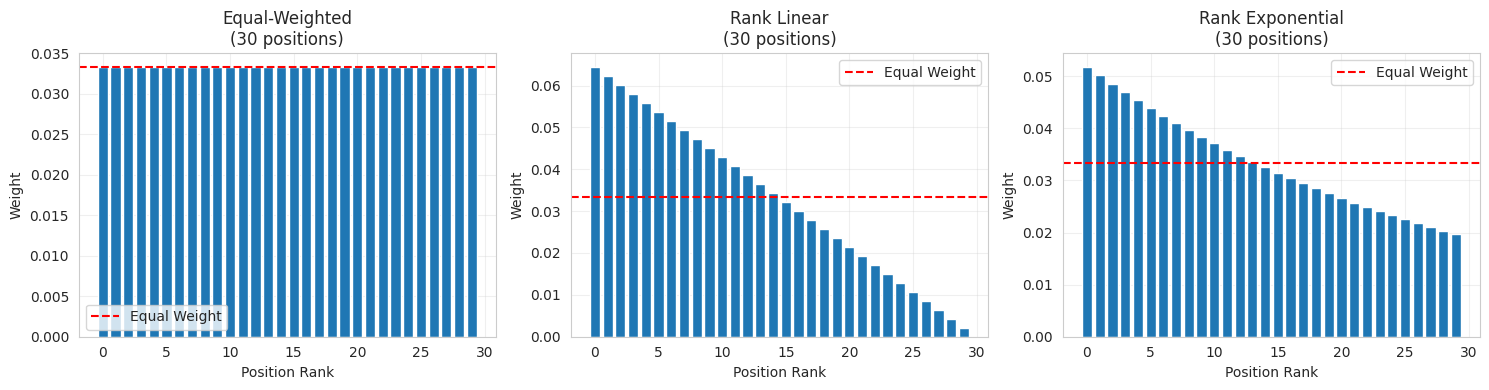

Weight concentration:
  Equal-Weighted: Top 10 positions = 33.3%
  Rank Linear: Top 10 positions = 54.8%
  Rank Exponential: Top 10 positions = 44.8%


In [4]:
# Visualize weight distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (name, weights) in enumerate(portfolios.items()):
    sorted_weights = weights.sort_values(ascending=False)
    
    axes[i].bar(range(len(sorted_weights)), sorted_weights.values)
    axes[i].set_title(f"{name}\n({len(weights)} positions)")
    axes[i].set_xlabel('Position Rank')
    axes[i].set_ylabel('Weight')
    axes[i].axhline(y=1/num_positions, color='r', linestyle='--', label='Equal Weight')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Weight concentration:")
for name, weights in portfolios.items():
    top_10_pct = weights.nlargest(10).sum()
    print(f"  {name}: Top 10 positions = {top_10_pct:.1%}")

## 3. Portfolio Construction at Scale

Test portfolio construction on different universe sizes:
- Pilot: 100 ETFs
- Medium: 200 ETFs
- Full: All available ETFs

In [5]:
def construct_portfolio(scores: pd.Series, universe_name: str, num_etfs: int = None):
    """Construct portfolio for a given universe size."""
    
    # Select top N ETFs by score
    if num_etfs is not None:
        eligible_scores = scores.nlargest(num_etfs)
    else:
        eligible_scores = scores
    
    print(f"\n{'='*60}")
    print(f"{universe_name.upper()} - {len(eligible_scores)} ETFs")
    print(f"{'='*60}")
    
    # Create optimizer
    optimizer = SimpleOptimizer(
        num_positions=30,
        min_score=None  # No minimum score filter
    )
    
    # Optimize
    weights = optimizer.optimize(eligible_scores)
    
    # Get position info
    info = optimizer.get_position_info(weights, eligible_scores)
    
    print(f"\nPortfolio Summary:")
    print(f"  Positions: {len(weights)}")
    print(f"  Total weight: {weights.sum():.2%}")
    print(f"  Avg factor score: {info['factor_score'].mean():.3f}")
    print(f"  Min factor score: {info['factor_score'].min():.3f}")
    
    print(f"\nTop 10 Holdings:")
    print(info.head(10).to_string())
    
    return weights, info

# Test on three scales
pilot_weights, pilot_info = construct_portfolio(integrated_scores, "Pilot", num_etfs=100)
medium_weights, medium_info = construct_portfolio(integrated_scores, "Medium", num_etfs=200)
full_weights, full_info = construct_portfolio(integrated_scores, "Full", num_etfs=None)


PILOT - 100 ETFs

Portfolio Summary:
  Positions: 30
  Total weight: 100.00%
  Avg factor score: 0.995
  Min factor score: 0.730

Top 10 Holdings:
           weight  factor_score
ETF_179  0.033333      1.736828
ETF_209  0.033333      1.639046
ETF_167  0.033333      1.510340
ETF_125  0.033333      1.378110
ETF_113  0.033333      1.336944
ETF_003  0.033333      1.266661
ETF_031  0.033333      1.115054
ETF_120  0.033333      1.066048
ETF_248  0.033333      1.063222
ETF_135  0.033333      1.047229

MEDIUM - 200 ETFs

Portfolio Summary:
  Positions: 30
  Total weight: 100.00%
  Avg factor score: 0.995
  Min factor score: 0.730

Top 10 Holdings:
           weight  factor_score
ETF_179  0.033333      1.736828
ETF_209  0.033333      1.639046
ETF_167  0.033333      1.510340
ETF_125  0.033333      1.378110
ETF_113  0.033333      1.336944
ETF_003  0.033333      1.266661
ETF_031  0.033333      1.115054
ETF_120  0.033333      1.066048
ETF_248  0.033333      1.063222
ETF_135  0.033333      1.047229

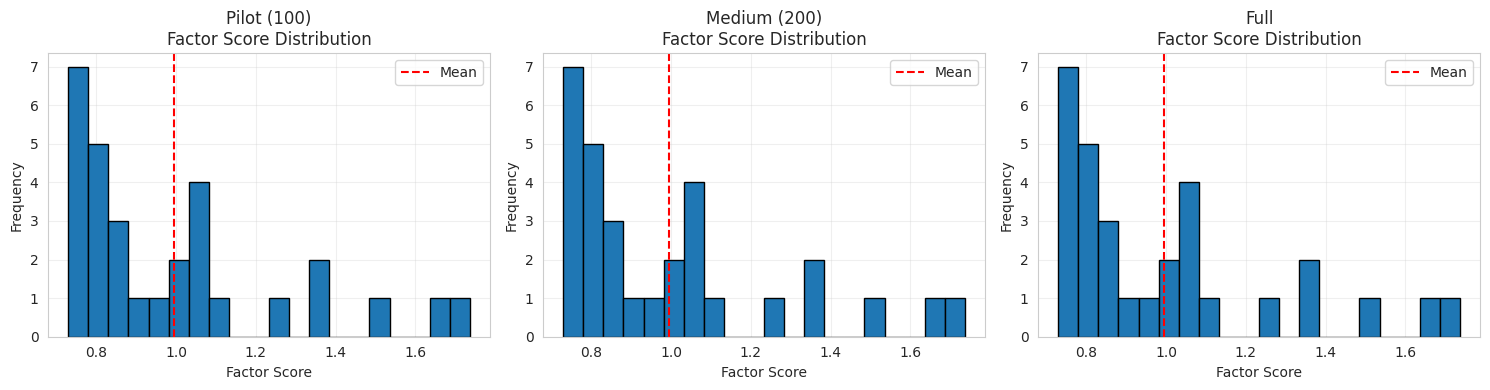

In [6]:
# Compare factor score distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (name, info) in enumerate([
    ('Pilot (100)', pilot_info),
    ('Medium (200)', medium_info),
    ('Full', full_info)
]):
    axes[i].hist(info['factor_score'], bins=20, edgecolor='black')
    axes[i].axvline(info['factor_score'].mean(), color='r', linestyle='--', label='Mean')
    axes[i].set_title(f"{name}\nFactor Score Distribution")
    axes[i].set_xlabel('Factor Score')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Rebalancing Strategy

Demonstrate threshold-based and periodic rebalancing.

In [7]:
# Simulate portfolio drift
np.random.seed(42)

# Start with equal weights
current_weights = pilot_weights.copy()
target_weights = pilot_weights.copy()

print("Initial Portfolio:")
print(f"  Positions: {len(current_weights)}")
print(f"  Total weight: {current_weights.sum():.2%}")

# Simulate market drift over 30 days
print("\nSimulating 30 days of market drift...")

for day in range(30):
    # Random returns for each position
    returns = np.random.randn(len(current_weights)) * 0.01
    
    # Update weights (some positions grow, others shrink)
    current_weights = current_weights * (1 + returns)
    current_weights = current_weights / current_weights.sum()  # Renormalize

print(f"\nAfter 30 days:")
print(f"  Total weight: {current_weights.sum():.2%}")
print(f"  Max weight: {current_weights.max():.2%} (target: {target_weights.max():.2%})")
print(f"  Min weight: {current_weights.min():.2%} (target: {target_weights.min():.2%})")

# Calculate drift
drift = (current_weights - target_weights).abs()
print(f"\nDrift Statistics:")
print(f"  Max drift: {drift.max():.2%}")
print(f"  Mean drift: {drift.mean():.2%}")
print(f"  Positions with >2% drift: {(drift > 0.02).sum()}")

Initial Portfolio:
  Positions: 30
  Total weight: 100.00%

Simulating 30 days of market drift...

After 30 days:
  Total weight: 100.00%
  Max weight: 3.68% (target: 3.33%)
  Min weight: 3.04% (target: 3.33%)

Drift Statistics:
  Max drift: 0.35%
  Mean drift: 0.14%
  Positions with >2% drift: 0


In [8]:
# Test threshold rebalancer
rebalancer = ThresholdRebalancer(
    drift_threshold=0.05,  # 5% drift threshold
    min_trade_size=0.01,   # 1% minimum trade size
)

decision = rebalancer.check_rebalance(
    current_weights=current_weights,
    target_weights=target_weights,
    current_date=pd.Timestamp('2024-01-30')
)

print(f"Rebalancing Decision:")
print(f"  Should rebalance: {decision.should_rebalance}")
print(f"  Reason: {decision.reason}")
print(f"  Max drift: {decision.drift:.2%}")
print(f"  Trades needed: {len(decision.trades)}")

if decision.should_rebalance:
    print(f"\nTop 5 Trades (by absolute size):")
    top_trades = decision.trades.abs().nlargest(5)
    for ticker in top_trades.index:
        trade = decision.trades[ticker]
        print(f"  {ticker}: {trade:+.3%} ({'buy' if trade > 0 else 'sell'})")

Rebalancing Decision:
  Should rebalance: False
  Reason: Drift 0.35% within threshold
  Max drift: 0.35%
  Trades needed: 0


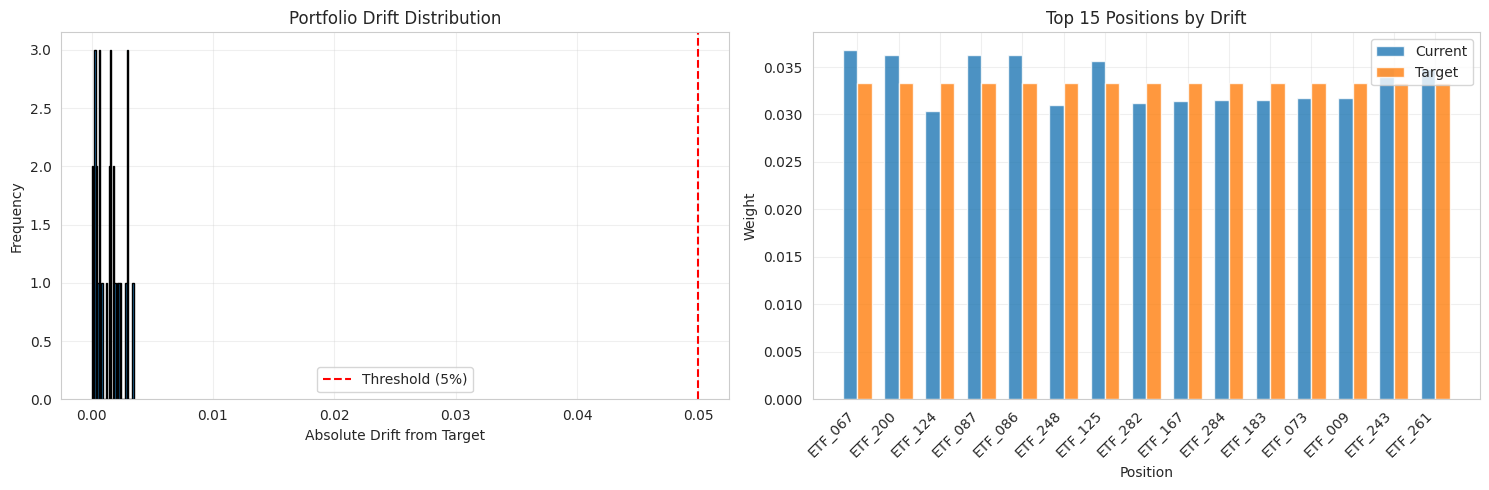

In [9]:
# Visualize drift
drift_df = pd.DataFrame({
    'Current': current_weights,
    'Target': target_weights,
    'Drift': drift
}).sort_values('Drift', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Drift distribution
axes[0].hist(drift, bins=30, edgecolor='black')
axes[0].axvline(0.05, color='r', linestyle='--', label='Threshold (5%)')
axes[0].set_title('Portfolio Drift Distribution')
axes[0].set_xlabel('Absolute Drift from Target')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Top drifters
top_drifters = drift_df.head(15)
x = np.arange(len(top_drifters))
width = 0.35

axes[1].bar(x - width/2, top_drifters['Current'], width, label='Current', alpha=0.8)
axes[1].bar(x + width/2, top_drifters['Target'], width, label='Target', alpha=0.8)
axes[1].set_title('Top 15 Positions by Drift')
axes[1].set_xlabel('Position')
axes[1].set_ylabel('Weight')
axes[1].set_xticks(x)
axes[1].set_xticklabels(top_drifters.index, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Risk Management

Demonstrate stop-loss and volatility-based risk management.

In [10]:
# Create stop-loss manager
stop_loss_mgr = StopLossManager(
    position_stop_loss=0.15,    # 15% position stop-loss
    portfolio_stop_loss=0.20,   # 20% portfolio drawdown limit
    trailing_stop=True,
    trailing_distance=0.10
)

# Simulate portfolio with some losing positions
np.random.seed(42)
entry_prices = pd.Series(
    np.random.uniform(100, 200, len(pilot_weights)),
    index=pilot_weights.index
)

# Add positions to manager
for ticker, price in entry_prices.items():
    stop_loss_mgr.add_position(ticker, price)

# Simulate current prices (some losses)
price_changes = np.random.uniform(0.70, 1.10, len(entry_prices))  # -30% to +10%
current_prices = entry_prices * price_changes

# Calculate losses
losses = (entry_prices - current_prices) / entry_prices
losses_df = pd.DataFrame({
    'Entry': entry_prices,
    'Current': current_prices,
    'Loss': losses
}).sort_values('Loss', ascending=False)

print("Position Losses:")
print(f"  Mean loss: {losses.mean():.2%}")
print(f"  Max loss: {losses.max():.2%}")
print(f"  Positions with >15% loss: {(losses > 0.15).sum()}")

print(f"\nTop 10 Losing Positions:")
print(losses_df.head(10).to_string())

Position Losses:
  Mean loss: 10.14%
  Max loss: 28.62%
  Positions with >15% loss: 13

Top 10 Losing Positions:
              Entry     Current      Loss
ETF_067  183.244264  130.791585  0.286245
ETF_200  159.241457  114.349844  0.281909
ETF_167  173.199394  125.746335  0.273979
ETF_065  119.967378   88.223650  0.264603
ETF_120  186.617615  137.923265  0.260931
ETF_178  102.058449   76.422928  0.251185
ETF_209  195.071431  149.855755  0.231790
ETF_009  129.122914   99.933618  0.226058
ETF_183  151.423444  117.866971  0.221607
ETF_162  118.182497   94.961053  0.196488


In [11]:
# Check risk signal
portfolio_value = 100000

signal = stop_loss_mgr.check_risk(
    current_prices=current_prices,
    weights=pilot_weights,
    portfolio_value=portfolio_value
)

print(f"Risk Management Signal:")
print(f"  Action: {signal.action}")
print(f"  Reason: {signal.reason}")
print(f"  Severity: {signal.severity}")
print(f"  Positions to close: {len(signal.positions_to_close)}")
print(f"  Positions to reduce: {len(signal.positions_to_reduce)}")

if len(signal.positions_to_close) > 0:
    print(f"\nPositions triggering stop-loss:")
    for ticker in signal.positions_to_close:
        loss = losses[ticker]
        print(f"  {ticker}: {loss:.2%} loss")

Stop-loss triggered for ETF_209: 23.18% loss (threshold: 15.00%)
Stop-loss triggered for ETF_167: 27.40% loss (threshold: 15.00%)
Stop-loss triggered for ETF_031: 17.82% loss (threshold: 15.00%)
Stop-loss triggered for ETF_120: 26.09% loss (threshold: 15.00%)
Stop-loss triggered for ETF_178: 25.12% loss (threshold: 15.00%)
Stop-loss triggered for ETF_067: 28.62% loss (threshold: 15.00%)
Stop-loss triggered for ETF_162: 19.65% loss (threshold: 15.00%)
Stop-loss triggered for ETF_284: 17.53% loss (threshold: 15.00%)
Stop-loss triggered for ETF_009: 22.61% loss (threshold: 15.00%)
Stop-loss triggered for ETF_065: 26.46% loss (threshold: 15.00%)
Stop-loss triggered for ETF_183: 22.16% loss (threshold: 15.00%)
Stop-loss triggered for ETF_200: 28.19% loss (threshold: 15.00%)
Stop-loss triggered for ETF_086: 16.99% loss (threshold: 15.00%)


Risk Management Signal:
  Action: stop_loss
  Reason: Stop-loss triggered on 13 positions
  Severity: medium
  Positions to close: 13
  Positions to reduce: 0

Positions triggering stop-loss:
  ETF_209: 23.18% loss
  ETF_167: 27.40% loss
  ETF_031: 17.82% loss
  ETF_120: 26.09% loss
  ETF_178: 25.12% loss
  ETF_067: 28.62% loss
  ETF_162: 19.65% loss
  ETF_284: 17.53% loss
  ETF_009: 22.61% loss
  ETF_065: 26.46% loss
  ETF_183: 22.16% loss
  ETF_200: 28.19% loss
  ETF_086: 16.99% loss


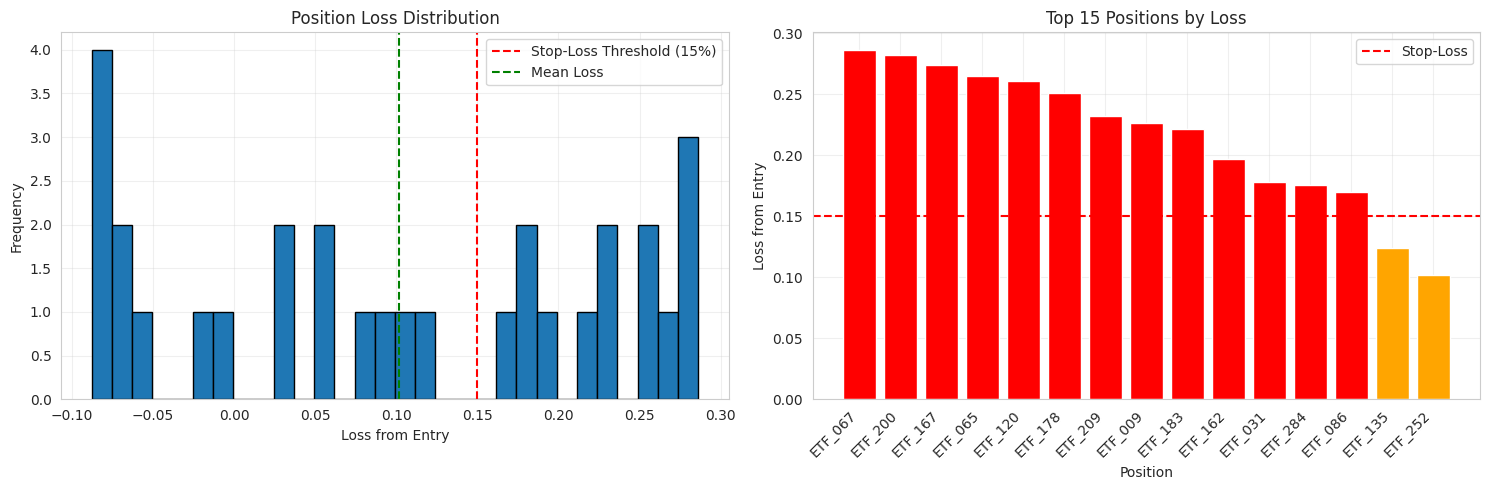

In [12]:
# Visualize risk metrics
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss distribution
axes[0].hist(losses, bins=30, edgecolor='black')
axes[0].axvline(0.15, color='r', linestyle='--', label='Stop-Loss Threshold (15%)')
axes[0].axvline(losses.mean(), color='g', linestyle='--', label='Mean Loss')
axes[0].set_title('Position Loss Distribution')
axes[0].set_xlabel('Loss from Entry')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Risk by position
risk_df = losses_df.head(15).copy()
colors = ['red' if loss > 0.15 else 'orange' if loss > 0.10 else 'yellow' 
          for loss in risk_df['Loss']]

axes[1].bar(range(len(risk_df)), risk_df['Loss'], color=colors)
axes[1].axhline(0.15, color='r', linestyle='--', label='Stop-Loss')
axes[1].set_title('Top 15 Positions by Loss')
axes[1].set_xlabel('Position')
axes[1].set_ylabel('Loss from Entry')
axes[1].set_xticks(range(len(risk_df)))
axes[1].set_xticklabels(risk_df.index, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Volatility-Based Exposure

Demonstrate volatility targeting to dynamically adjust portfolio exposure.

In [13]:
# Create volatility manager
vol_mgr = VolatilityManager(
    target_volatility=0.15,  # Target 15% annual volatility
    lookback=60,
    min_leverage=0.5,
    max_leverage=1.0
)

# Simulate different volatility regimes
regimes = {
    'Low Vol (10%)': 0.0063,   # 10% annual = 0.63% daily
    'Target (15%)': 0.0095,    # 15% annual = 0.95% daily
    'High Vol (25%)': 0.0157,  # 25% annual = 1.57% daily
    'Crisis (40%)': 0.0252     # 40% annual = 2.52% daily
}

results = []

for name, daily_vol in regimes.items():
    # Generate returns
    np.random.seed(42)
    returns = pd.Series(np.random.randn(100) * daily_vol)
    
    # Calculate recommended exposure
    exposure = vol_mgr.calculate_exposure(returns)
    
    # Adjust weights
    adjusted_weights = vol_mgr.adjust_weights(pilot_weights, returns)
    
    results.append({
        'Regime': name,
        'Realized Vol': returns.std() * np.sqrt(252),
        'Exposure': exposure,
        'Cash %': 1 - adjusted_weights.sum()
    })

results_df = pd.DataFrame(results)
print("\nVolatility Targeting Results:")
print(results_df.to_string(index=False))


Volatility Targeting Results:
        Regime  Realized Vol  Exposure   Cash %
 Low Vol (10%)      0.090825  1.000000 0.000000
  Target (15%)      0.136959  1.000000 0.000000
High Vol (25%)      0.226343  0.686347 0.313653
  Crisis (40%)      0.363302  0.500000 0.500000


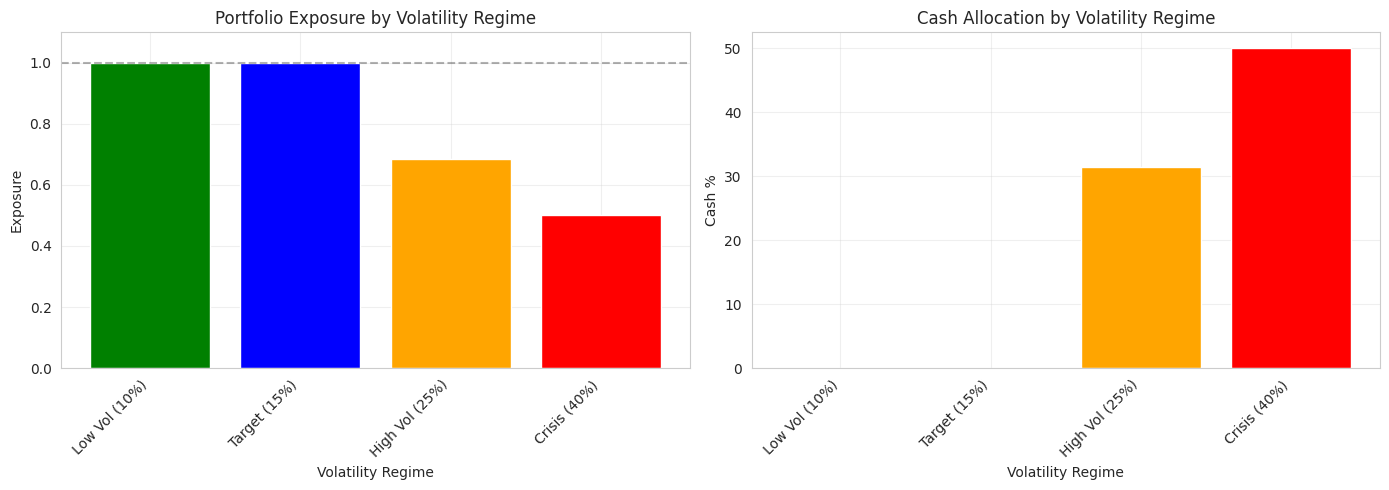

In [14]:
# Visualize exposure adjustment
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Exposure by volatility regime
axes[0].bar(range(len(results_df)), results_df['Exposure'], 
            color=['green', 'blue', 'orange', 'red'])
axes[0].set_title('Portfolio Exposure by Volatility Regime')
axes[0].set_xlabel('Volatility Regime')
axes[0].set_ylabel('Exposure')
axes[0].set_xticks(range(len(results_df)))
axes[0].set_xticklabels(results_df['Regime'], rotation=45, ha='right')
axes[0].axhline(1.0, color='black', linestyle='--', alpha=0.3)
axes[0].set_ylim(0, 1.1)
axes[0].grid(True, alpha=0.3)

# Cash allocation
axes[1].bar(range(len(results_df)), results_df['Cash %'] * 100,
            color=['green', 'blue', 'orange', 'red'])
axes[1].set_title('Cash Allocation by Volatility Regime')
axes[1].set_xlabel('Volatility Regime')
axes[1].set_ylabel('Cash %')
axes[1].set_xticks(range(len(results_df)))
axes[1].set_xticklabels(results_df['Regime'], rotation=45, ha='right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Summary

Portfolio construction framework successfully demonstrated:

### Key Components
1. **Optimizer**: Constructs portfolios from factor scores
   - Equal-weighted approach
   - Rank-based weighting schemes
   - Tested on 100, 200, and full ETF universe

2. **Rebalancer**: Threshold-based rebalancing
   - Monitors portfolio drift
   - Triggers rebalance when drift exceeds 5%
   - Minimizes unnecessary trading

3. **Risk Manager**: Stop-loss protection
   - 15% position stop-loss
   - 20% portfolio drawdown limit
   - Trailing stops to lock in gains

4. **Volatility Targeting**: Dynamic exposure adjustment
   - Target 15% annual volatility
   - Increases cash in high volatility
   - Full exposure in low volatility

### Next Steps
- Backtest these strategies on historical data
- Optimize rebalancing thresholds
- Test different risk management parameters
- Implement transaction cost modeling

In [15]:
print(f"\n{'='*60}")
print("PORTFOLIO CONSTRUCTION NOTEBOOK COMPLETE")
print(f"{'='*60}")
print(f"Completed: {datetime.now()}")
print(f"\nPortfolios constructed for:")
print(f"  - Pilot: {len(pilot_weights)} positions")
print(f"  - Medium: {len(medium_weights)} positions")
print(f"  - Full: {len(full_weights)} positions")


PORTFOLIO CONSTRUCTION NOTEBOOK COMPLETE
Completed: 2025-10-10 15:22:10.580385

Portfolios constructed for:
  - Pilot: 30 positions
  - Medium: 30 positions
  - Full: 30 positions
